In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torchvision.utils import draw_bounding_boxes

In [22]:
import warnings

warnings.filterwarnings("ignore")

In [12]:
sys.path.insert(
    0, os.path.abspath(os.path.join(os.getcwd(), "../../DermSynth3D_private"))
)

from dermsynth3d.datasets.datasets import (
    ImageDataset,
    RealDataset_Detection,
)
from dermsynth3d.models.model import faster_rcnn_texture_model
from dermsynth3d.utils.evaluate_detection import (
    evaluate_detection,
)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
img_size = (256, 256)

In [15]:
det_model = faster_rcnn_texture_model(
    device,
    num_classes=2,
    max_input_size=img_size[0],
    pretrained_backbone=True,
)
det_model.load_state_dict(torch.load("/path/to/trained/model"), strict=False)

<All keys matched successfully>

In [16]:
det_model = det_model.to(device)
det_model.eval();

In [17]:
# Assumes the model was pretrained using these values.
preprocess_input = A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
img_preprocess = A.Compose(
    [
        preprocess_input,
    ]
)

# To force a resize of the input image.
resize_func = A.Resize(height=img_size[0], width=img_size[1])
# Perform spatial augmentation on both the image and mask.
spatial_augment = A.Compose(
    [
        resize_func,
    ]
)

<h2>Foot Ulcer Segmentation Challenge (FUSeg) Images</h2>

https://github.com/uwm-bigdata/wound-segmentation/tree/master/data/Foot%20Ulcer%20Segmentation%20Challenge

See instructions to download the images.

Update `dir_wounds` to the directory containing the FUSeg images and labels.

In [18]:
# Where the FUSeg images are stored.
dir_wounds = "../data/FUSeg/test"
dir_wounds_images = os.path.join(dir_wounds, "images")
dir_wounds_targets = os.path.join(dir_wounds, "labels")
wounds_test_ds = RealDataset_Detection(
    dir_images=dir_wounds_images,
    dir_targets=dir_wounds_targets,
    name="wounds",
    image_extension=".png",
    target_extension=".png",
    image_augment=None,
    spatial_transform=spatial_augment,
    image_preprocess=img_preprocess,
    totensor=ToTensorV2(transpose_mask=True),
)

print(len(wounds_test_ds))

200


In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [20]:
wounds_test_dataloader = DataLoader(
    wounds_test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn
)

<h3>Compute the results</h3>

In [23]:
centroid_result, iou_result = evaluate_detection(
    det_model, wounds_test_dataloader, device
)
ap_centroid = pd.DataFrame(centroid_result).ap.mean()
iou = pd.DataFrame(iou_result).iou.mean()
print(
    "IoU: {:.2f} \nAP (centrouid): {:.2f}".format(
        iou,
        ap_centroid,
    )
)

IoU: 0.48 
AP (centrouid): 0.82


<h3>Result Visualization</h3>

In [24]:
idx = 10
file_id = wounds_test_ds.file_ids[idx]

In [26]:
transform_1 = transforms.Compose([transforms.PILToTensor()])
transform_2 = transforms.Compose([transforms.ToPILImage()])
cpu_device = torch.device("cpu")

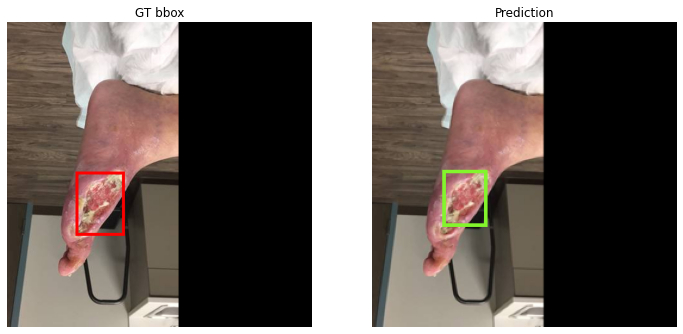

In [27]:
plt.figure(figsize=(12, 20))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title("GT bbox")
boxes = wounds_test_ds.bbox(file_id)
img = wounds_test_ds.image(file_id)
img_tensor = transform_1(img)
drawn_boxes_gt = draw_bounding_boxes(img_tensor, boxes, colors="red", width=5)
drawn_boxes_img_gt = transform_2(drawn_boxes_gt)
plt.axis("off")
plt.imshow(drawn_boxes_img_gt)

spatial = wounds_test_ds.spatial_transform(image=np.asarray(img), mask=np.asarray(img))
preprocess_image = img_preprocess(image=spatial["image"])
img = preprocess_image["image"]
img_tensor = transforms.ToTensor()(img).to(device).float()

img1 = wounds_test_ds.image(file_id)
img1 = img1.resize(img_size)
img_tensor1 = transform_1(img1)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title("Prediction")
output = det_model([img_tensor])[0]
predicted_boxes = output["boxes"].to(cpu_device)
predicted_scores = output["scores"].to(cpu_device)

drawn_boxes_pred_real = draw_bounding_boxes(
    img_tensor1, predicted_boxes[predicted_scores > 0.5], colors="#83F52C", width=3
)
drawn_boxes_img_pred_real = transform_2(drawn_boxes_pred_real)
plt.axis("off")
plt.imshow(drawn_boxes_img_pred_real)